# Setup

Example Directory Structure (Panel = TUQ97N):

```
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/tissue-registry/xenium/TUQ97N$ tree
.
├── he
│   ├── alignment
│   │   └── Uninflamed-50336C
│   │       ├── keypoints.csv
│   │       └── matrix.csv
│   ├── ome-tiff
│   │   ├── Inflamed-50403B.ome.tif
│   │   ├── Stricture-50217C.ome.tif
│   │   ├── Stricture-50403C1.ome.tif
│   │   ├── Uninflamed-50217B.ome.tif
│   │   └── Uninflamed-50336C.ome.tif
│   └── raw
│       ├── 49377A2.ndpi
│       ├── 49464A4.ndpi
│       ├── 50217C.ndpi
│       ├── 50336C.ndpi
│       ├── 50403B.ndpi
│       ├── 50403C1.ndpi
├── if_p16p21p53
│   ├── alignment
│   ├── ome-tiff
│   └── raw
└── if_sabgal
    ├── alignment
    ├── ome-tiff
    └── raw
```



In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import functools
import matplotlib.pyplot as plt
import seaborn as sb
import scanpy as sc
import spatialdata
import spatialdata_io as sdio
import numpy as np
import pandas as pd
import corescpy as cr

pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500

# Count Threshold for Cell Quantification
count_threshold = 1

# Data & Output File Paths
panel = "TUQ97N"
lib = "50403C1"
# to convert all NDPIs to OME-TIFFs instead of 1 lib, see Loop All section
lib_suffix = ""
# put suffix ^ (e.g., _mucosa) if library/sample has a suffix in file names
dir_image_type = f"xenium/{panel}/he"  # subdirectory under tissue-registry
constants_dict = cr.get_panel_constants(panel_id=panel)
csid_orig, csid = [constants_dict[x]
                   for x in ["col_sample_id_o", "col_sample_id"]]
dir_nfs = "/mnt/cho_lab/bbdata2"
dir_data = os.path.join(dir_nfs, "outputs", )
out_dir = str(f"/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/"
              f"outputs/{panel}/nebraska")  # change if needed
# out_dir = os.path.join(dir_data, "nebraska")  # if objects & images on NFS
mdf = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(out_dir))),
                   "samples.csv")  # path to metadata (LabKey export)
dir_path = os.path.join(out_dir, "tissue-registry", dir_image_type)

# Annotation File Path & Clustering Versions & Label Columns to Use Downstream
file_ann = os.path.join(
    out_dir, "annotation_dictionaries/annotations_all.xlsx")  # annotations
col_leiden = "leiden_res1pt5_dist0_npc30"  # high resolution
# c_t = "leiden_res0pt75_dist0pt3_npc30"  # medium resolution
# c_t = "leiden_res0pt5_dist0pt5_npc30"  # low resolution
c_ann = "bucket"  # annotation column in annotation dictionary
col_cell_type = c_ann + "_" + col_leiden.split("leiden_")[1]  # anndata column

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Metadata & Construct Standardized Files

You shouldn't have to change any code/variables here unless our process/conventions change (e.g., file naming/directory structure, using the NFS for pathology images input &/or output).

In [30]:
# Load Metadata & Find Output Sample ID (e.g., Uninflamed-50336C)
metadata = cr.pp.get_metadata_cho(dir_nfs, mdf, panel_id=panel)
libid = metadata.reset_index().set_index(csid_orig).loc[lib][csid]

# Image Data Paths
file_align = os.path.join(dir_path,
                          f"alignment/{libid}{lib_suffix}/matrix.csv")
file_image = (os.path.join(dir_path, f"raw/{lib}{lib_suffix}.ndpi"),
              os.path.join(dir_path, f"ome-tiff/{libid}{lib_suffix}.ome.tif")
              )  # raw NDPI file, output OME-TIFF file

# Print Conversion Information (If Applicable)
if os.path.exists(file_image[1]) is False:  # convert to ome-tiff if needed
    print("\n\nConverting\n" + "\nto \n".join(file_image))



Converting
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/tissue-registry/xenium/TUQ97N/he/raw/50403C1.ndpi
to 
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/tissue-registry/xenium/TUQ97N/he/ome-tiff/Stricture-50403C1.ome.tif


# Convert OME-TIFF (if Needed)

## One Sample

In [31]:
if os.path.exists(file_image[1]) is False:  # convert to ome-tiff if needed
    cr.tl.write_ome_tif(file_image[0], file_image[1], bf_cmd="bfconvert")



Converting
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/tissue-registry/xenium/TUQ97N/he/raw/50403C1.ndpi
to 
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/tissue-registry/xenium/TUQ97N/he/ome-tiff/Stricture-50403C1.ome.tif


## Loop All

In [ ]:
# for x in os.listdir(os.path.join(dir_path, "raw")):
#     lib = os.path.splitext(x)[0]
#     if "-" in lib and lib not in metadata[
#         	csid_orig].to_list():  # if >1 sample in images
#         libid = "-".join([metadata.reset_index().set_index(csid_orig).loc[
#             u][csid] for u in lib.split("-")])
#     else:
#         libid = metadata.reset_index().set_index(csid_orig).loc[lib][csid]
#     print(lib, libid)
#     file_align = os.path.join(dir_path,
#                               f"alignment/{libid}{lib_suffix}/matrix.csv")
#     f_im = (os.path.join(dir_path, f"raw/{lib}{lib_suffix}.ndpi"),
#             os.path.join(dir_path, f"ome-tiff/{libid}{lib_suffix}.ome.tif"))
#     if os.path.exists(f_im[1]) is False:  # to ome-tiff if need
#         print("\n\nConverting\n" + "\nto \n".join(f_im))
#         cr.tl.write_ome_tif(f_im[0], f_im[1], bf_cmd="bfconvert")
#     else:
#         print(f"{f_im[1]} exists")

# Object

In [10]:
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])
file_path = np.array(files)[np.where(["-".join(libid.split("-")[
    1:]) == os.path.basename(x).split("__")[2].split(
        "-")[0] for x in files])[0][0]]
self = cr.Spatial(os.path.join(dir_data, file_path), library_id=libid,
                  col_cell_type=col_cell_type, n_jobs=16)
self.update_from_h5ad(os.path.join(out_dir, libid + ".h5ad"))
self.get_layer("counts", inplace=True)
self.adata



<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-012/output-XETG00189__0021978__50403C1-TUQ97N-EA__20240516__190239
         /cell_feature_matrix.h5                                                                                   


Counts: Initial


	Observations: 722162

	Genes: 469







 AnnData object with n_obs × n_vars = 722162 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts' 

                      gene_ids    feature_types   genome
gene_symbols                     

SpatialData object with:
├── Images
│     └── 'morphology_focus': MultiscaleSpatialImage[cyx] (5, 85015, 51278), (5, 42507, 25639), (5, 21253, 12819), (5, 10626, 6409), (5, 5313, 3204)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (85015, 51278), (42507, 25639), (21253, 12819), (10626, 6409), (5313, 3204)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (85015, 51278), (42507, 25639), (21253, 12819), (10626, 6409), (5313, 3204)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (722162, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (722162, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (714771, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (653622, 469)
with coordinate systems:
▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shap

## Load Annotations

AnnData object with n_obs × n_vars = 653622 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample', 'Sample ID', 'Patient', 'Status', 'Slide Id', 'Project', 'Location', 'Stricture', 'GRID ID', 'Inflamed', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease_Status', 'Date Collected', 'Date Sectioned', 'Date Hybridization', 'Storage 4c', 'Created By', 'Created', 'Storage Status', 'Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Unnamed: 29', 'out_file', 'segmentation', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_nu

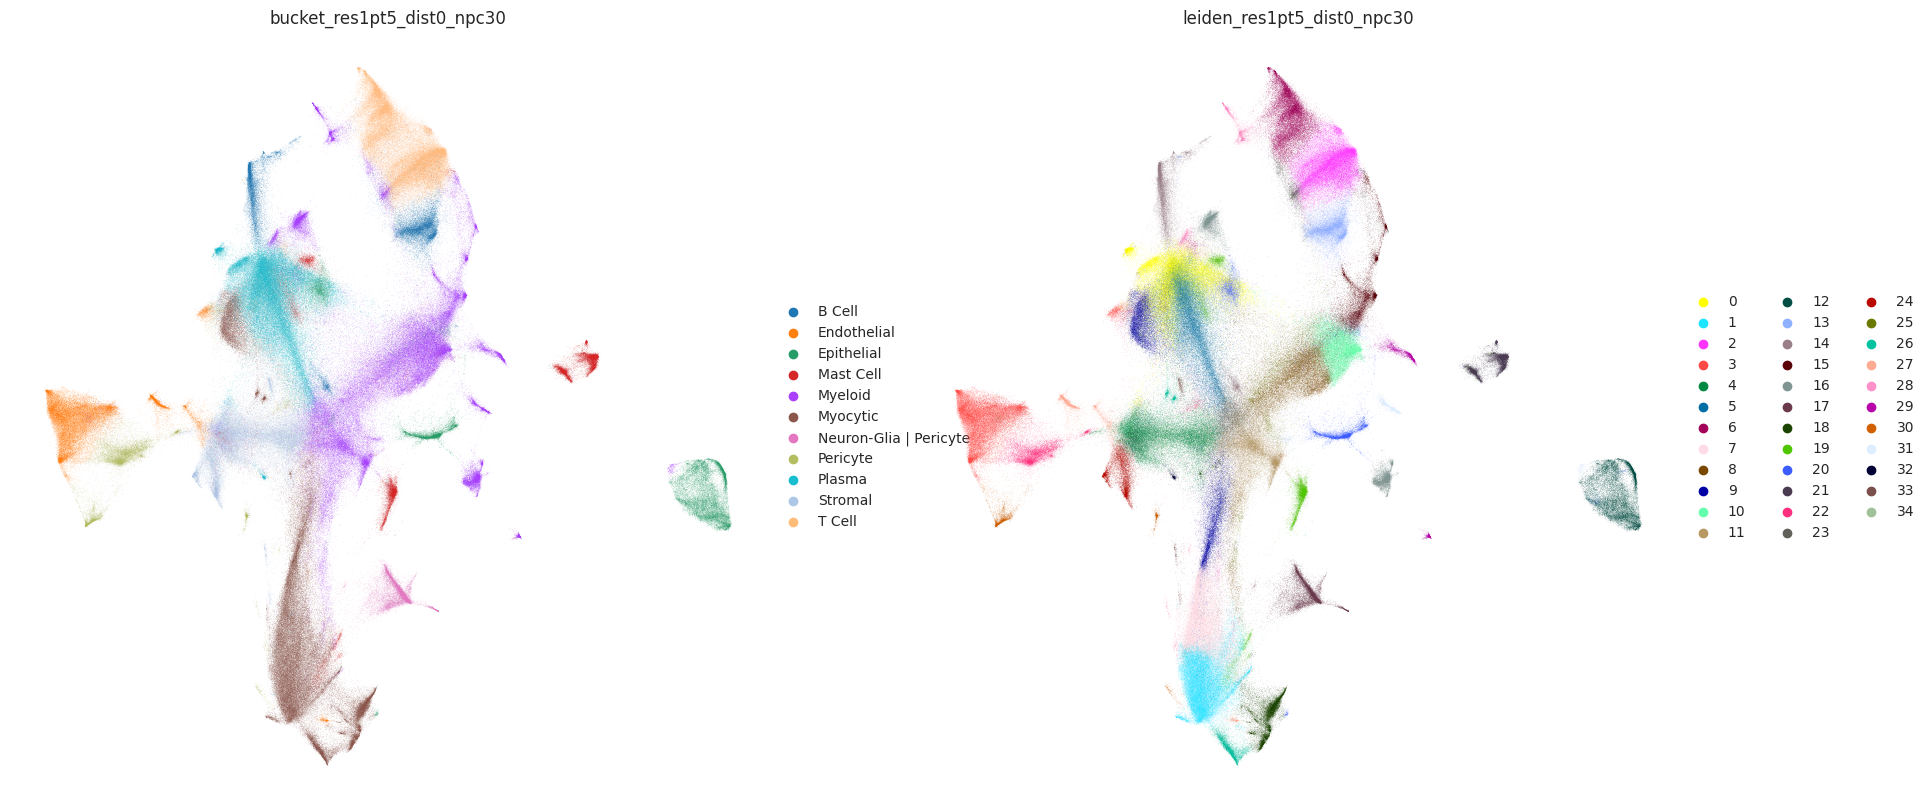

In [26]:
i_x = f"{self._library_id}___{col_leiden}_dictionary.xlsx"
if file_ann is not None:
    fmr = pd.read_excel(file_ann, index_col=[0, 1])
    if i_x not in [i[0] for i in fmr.index]:
        raise FileNotFoundError(f"{i_x} not found in annotation dictionary")
    self.annotate_clusters(fmr.loc[i_x][c_ann], col_annotation=col_cell_type,
                           copy=False, col_cell_type=col_leiden)  # annotation

## Load Image

If you haven't already, add the `bfconvert` command-line tool (https://docs.openmicroscopy.org/bio-formats/5.7.1/users/comlinetools/index.html) to your path. For instance, if the tool is stored in `/opt`:

`echo 'export PATH="$PATH:/opt/bftools/"" >> ~/.bashrc`.

In [ ]:
self.add_image(file_image[1], name="he", file_align=file_align)  # add image

In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# from napari_spatialdata import Interactive
# from spatialdata import SpatialData

# plt.rcParams["figure.figsize"] = (20, 20)

# sdata = self.adata
# interactive = Interactive(sdata)
# interactive.run()

# Render Images

In [ ]:
%%time

axes = plt.subplots(1, 2, figsize=(20, 13))[1].flatten()
# axes = plt.subplots(3, 1, figsize=(20, 13))[1].flatten()
self.adata.pl.render_images("he").pl.show(
    ax=axes[0], title="H&E", coordinate_systems="global")
self.adata.pl.render_images("morphology_focus").pl.show(
    ax=axes[1], title="Morphology", coordinate_systems="global")
# self.adata.pl.render_shapes(color=col_cell_type).pl.show(
#     ax=axes[2], title="Labels", coordinate_systems="global")

In [ ]:
self.adata.pl.render_images("morphology_focus").pl.show(
    title="Morphology", coordinate_systems="global", dpi=20)
self.adata.pl.render_shapes(elements="cell_boundaries", groups=[
    "1", "2"], color=col_cell_type).pl.show(coordinate_systems="global")

In [ ]:
axes = plt.subplots(1, 2, figsize=(30, 30))[1].flatten()
self.adata.pl.render_images("he").pl.show(
    ax=axes[0], title="H&E", coordinate_systems="global")
self.adata.pl.render_shapes(color=col_cell_type).pl.show(
    ax=axes[1], title="Labels", coordinate_systems="global")

In [ ]:
sdata = self.crop([800, 1000], [600, 800])

In [ ]:
sdata.pl.render_images("morphology_focus", scale="scale4").pl.show(
    title="Morphology", coordinate_systems="global")

In [ ]:
%%time

from spatialdata_io.experimental import to_legacy_anndata

adata = to_legacy_anndata(self.adata, include_images=True,
                          coordinate_system="transformed")
sc.pl.spatial(adata, library_id="morphology_focus", img_key="hires",
              na_color="white", show=True, crop_coord=(0, 2000, 0, 2000))

# Image Analysis

In [ ]:
for g in genes:
    sc.queries.enrich(adata, g)

# Workspace (IGNORE)

In [ ]:
import liana as li
from liana.method import MistyData, genericMistyData, lrMistyData
from liana.method.sp import RandomForestModel, LinearModel, RobustLinearModel
import decoupler as dc

organism = "human"
adata = sc.read(os.path.join(out_dir, libid + ".h5ad"))

adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

progeny = dc.get_progeny(organism=organism, top=500)
dc.run_mlm(mat=adata, net=progeny, source="source", target="target",
           weight="weight", verbose=True, use_raw=False)
acts_progeny = li.ut.obsm_to_adata(adata, "mlm_estimate")

adata.obsm["compositions"] =
comps = li.ut.obsm_to_adata(adata, "compositions")

misty = genericMistyData(intra=comps, extra=acts_progeny, cutoff=0.05,
                         bandwidth=200, coord_type="generic", n_rings=1)

hvg = adata.var[adata.var["highly_variable"]].index
misty(bypass_intra=True, model=LinearModel, verbose=True)


In [ ]:
# urls = str("https://figshare.com/ndownloader/files/41501073?"
#            "private_link=4744950f8768d5c8f68c')
# ann = sc.read("kuppe_heart19.h5ad", backup_url=urls)
# ann.obsm["compositions"]